In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# For downloading the traffic camera photo
import requests
from bs4 import BeautifulSoup

In [2]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

def draw_title(image,font,title):
    """Draw the title"""
    im_width, im_height = image.size
    draw = ImageDraw.Draw(image)
    w, h = font.getsize(title)
    # draw a box
    draw.rectangle((10, im_height-50, 10 + w, im_height-50 + h * 2.5), fill = 'black')
    # draw the title
    draw.multiline_text((10, im_height-50), title, font=font, fill=(255,255,255))
    
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()
                              ):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, title, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/Users/lingjie/Library/Fonts/JosefinSansLight-ZVEll.ttf", 20)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil,ymin,xmin,ymax,xmax,color,font,display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
            
    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    draw_title(image_pil,font, title)
    np.copyto(image, np.array(image_pil))
    
    return image

In [3]:
def get_url(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    title = soup.title.string
    links = soup.find_all('img')
    img_links = {}
    for link in links:
        if 'View from' in link.get('alt'):
            img_links[link.get('alt')] = 'http://' + link.get('src').replace('//', '')
    return img_links

In [4]:
def get_img(img_url):
    img = requests.get(img_url, stream=True)
    image_data = BytesIO(img.content)
    pil_image = Image.open(image_data)
#     pil_image = ImageOps.fit(pil_image, (512, 512), Image.ANTIALIAS) # resize photo
    return pil_image

In [5]:
def run_detector_car(detector, img_link):
    img = get_img(img_link)
    img_np = np.array(img)
    converted_img = tf.convert_to_tensor(img_np)
    converted_img  = tf.image.convert_image_dtype(converted_img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}
    
    car_index = (np.isin(np.array(result["detection_class_entities"], dtype='str'), 
                         ['Car', 'Vehicle', 'Land vehicle', 'Motorcycle'])) & (result["detection_scores"] >= 0.1) # min score

#     print("Found %d cars." % len(result["detection_scores"][car_index]))
#     print("Inference time: ", end_time-start_time)

    title = 'Found {} cars.\nInference time: {}'.format(len(result["detection_scores"][car_index]), end_time-start_time)
    
    image_with_boxes = draw_boxes(
        np.array(img_np, np.int32), result["detection_boxes"][car_index],
        result["detection_class_entities"][car_index], result["detection_scores"][car_index],
        title
    )

#     display_image(image_with_boxes)
    return {'num_cars' : len(result["detection_scores"][car_index]), 'time_taken' : end_time-start_time, 'img' : image_with_boxes}

In [6]:
def update_camera():
    traffic_cameras = {}
    for url in urls:
        traffic_cameras.update(get_url(url))
    return traffic_cameras

In [7]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
woodlands = 'https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/woodlands.html#trafficCameras'
kje = 'https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/kje.html#trafficCameras'
sle = 'https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/sle.html#trafficCameras'
tpe = 'https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/tpe.html#trafficCameras'
bke = 'https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/bke.html#trafficCameras'
aye = 'https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/aye.html#trafficCameras'
cte = 'https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/cte.html#trafficCameras'
mce = 'https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/mce.html#trafficCameras'
ecp = 'https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/ecp.html#trafficCameras'
pie = 'https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/pie.html#trafficCameras'
stg = 'https://www.onemotoring.com.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/stg.html#trafficCameras'
urls = [woodlands, kje, sle, tpe, bke, aye, cte, mce, ecp, pie, stg]

In [9]:
traffic_cameras = update_camera()

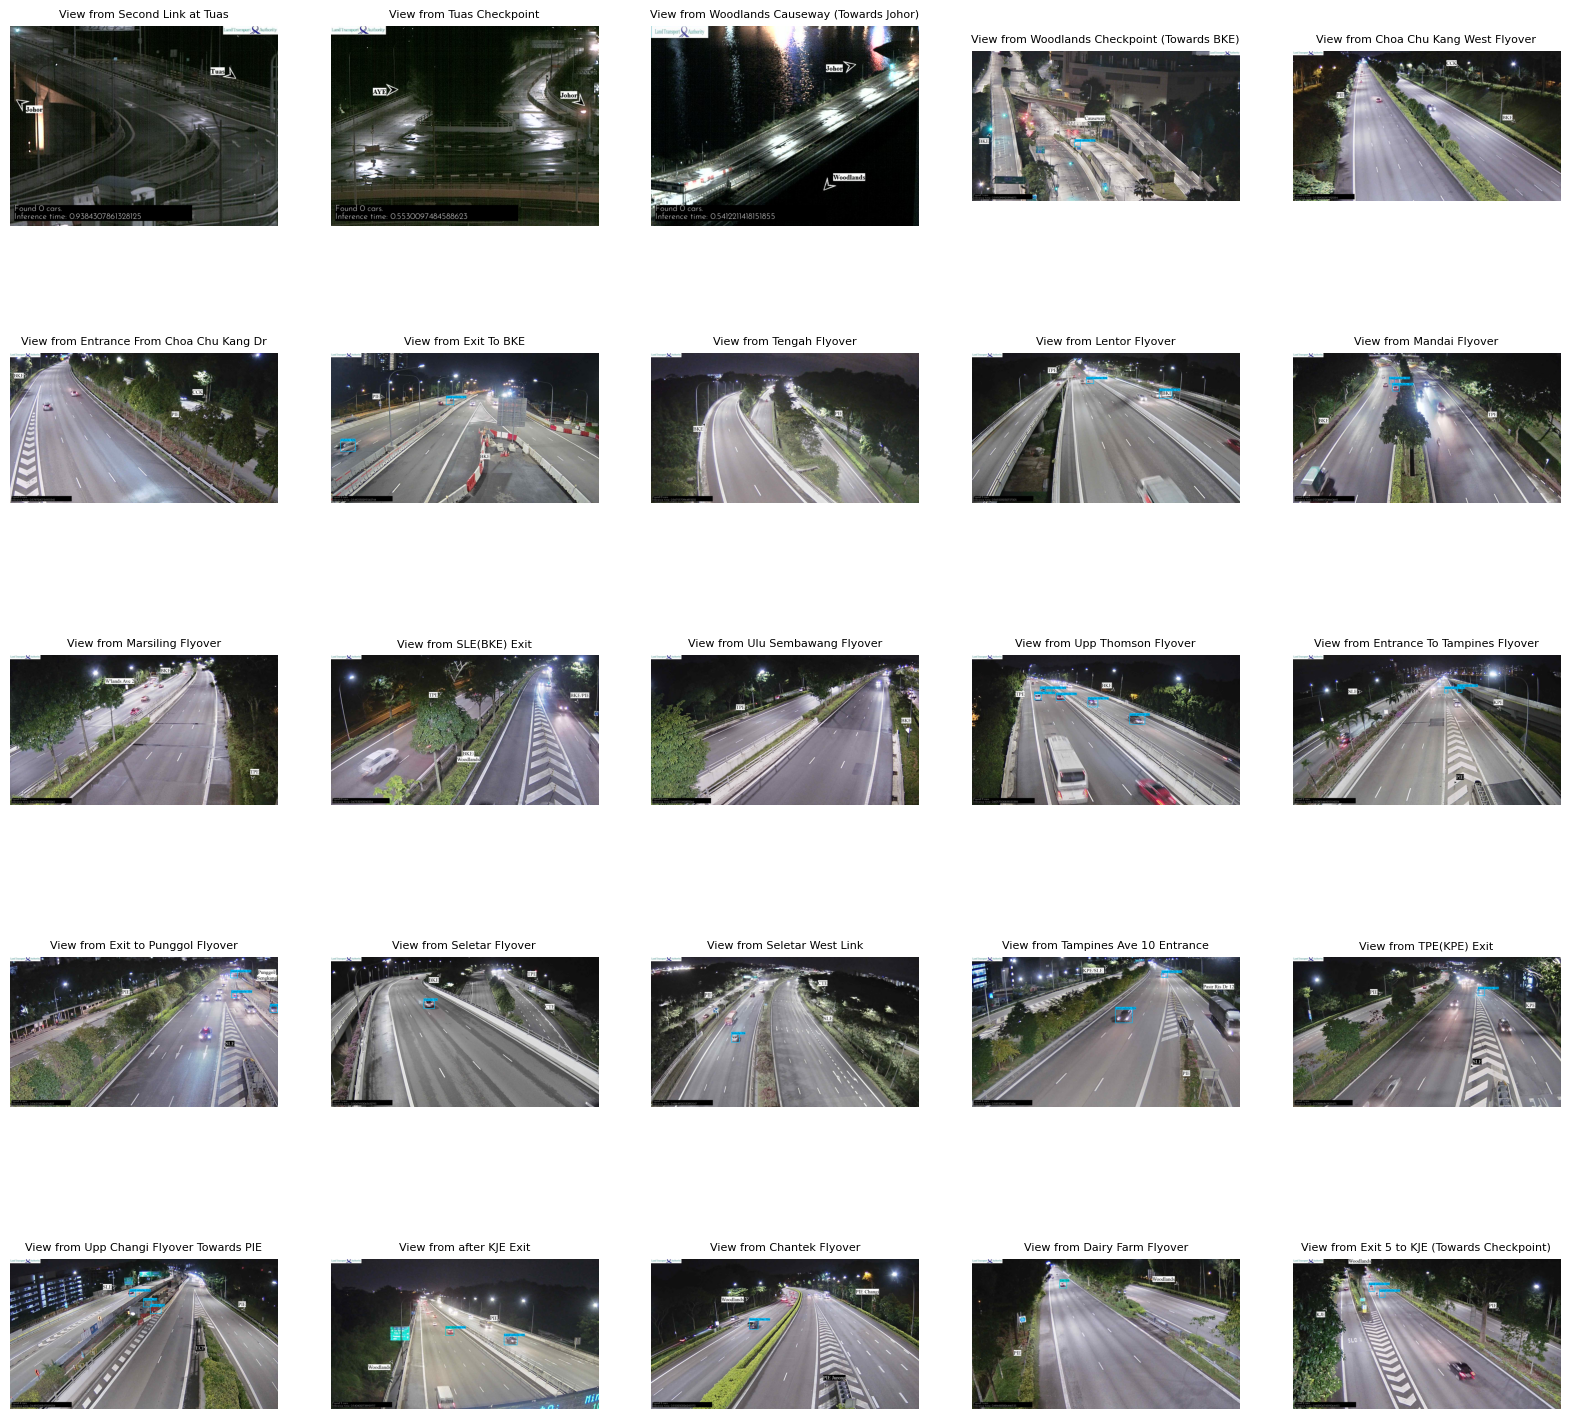

In [16]:
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, 5, figsize=(20,20), dpi=100, gridspec_kw={'hspace':0})
for ax, cam, title in zip(ax1, list(traffic_cameras.values())[:5], list(traffic_cameras.keys())[:5]):
    ax.axis('off')
    result = run_detector_car(detector, cam)
    ax.imshow(result['img'])
    ax.set_title(title, fontdict={'fontsize':8})
for ax, cam, title in zip(ax2, list(traffic_cameras.values())[5:10], list(traffic_cameras.keys())[5:10]):
    ax.axis('off')
    result = run_detector_car(detector, cam)
    ax.imshow(result['img'])
    ax.set_title(title, fontdict={'fontsize':8})
for ax, cam, title in zip(ax3, list(traffic_cameras.values())[10:15], list(traffic_cameras.keys())[10:15]):
    ax.axis('off')
    result = run_detector_car(detector, cam)
    ax.imshow(result['img'])
    ax.set_title(title, fontdict={'fontsize':8})
for ax, cam, title in zip(ax4, list(traffic_cameras.values())[15:20], list(traffic_cameras.keys())[15:20]):
    ax.axis('off')
    result = run_detector_car(detector, cam)
    ax.imshow(result['img'])
    ax.set_title(title, fontdict={'fontsize':8})
for ax, cam, title in zip(ax5, list(traffic_cameras.values())[20:25], list(traffic_cameras.keys())[20:25]):
    ax.axis('off')
    result = run_detector_car(detector, cam)
    ax.imshow(result['img'])
    ax.set_title(title, fontdict={'fontsize':8})

In [11]:
# fig.savefig('output/traffic_cam.jpg', dpi=600, bbox_inches='tight', facecolor='white')

In [12]:
# fig2, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, 5, figsize=(20,20), dpi=300, gridspec_kw={'hspace':0})
# for ax, cam, title in zip(ax1, list(traffic_cameras.values())[25:30], list(traffic_cameras.keys())[25:30]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# for ax, cam, title in zip(ax2, list(traffic_cameras.values())[30:35], list(traffic_cameras.keys())[30:35]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# for ax, cam, title in zip(ax3, list(traffic_cameras.values())[35:40], list(traffic_cameras.keys())[35:40]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# for ax, cam, title in zip(ax4, list(traffic_cameras.values())[40:45], list(traffic_cameras.keys())[40:45]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# for ax, cam, title in zip(ax5, list(traffic_cameras.values())[45:50], list(traffic_cameras.keys())[45:50]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# fig2.savefig('output/traffic_cam2.jpg', dpi=600, bbox_inches='tight', facecolor='white')

In [13]:
# fig3, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, 5, figsize=(20,20), dpi=300, gridspec_kw={'hspace':0})
# for ax, cam, title in zip(ax1, list(traffic_cameras.values())[50:55], list(traffic_cameras.keys())[50:55]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# for ax, cam, title in zip(ax2, list(traffic_cameras.values())[55:60], list(traffic_cameras.keys())[55:60]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# for ax, cam, title in zip(ax3, list(traffic_cameras.values())[60:65], list(traffic_cameras.keys())[60:65]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# for ax, cam, title in zip(ax4, list(traffic_cameras.values())[65:70], list(traffic_cameras.keys())[65:70]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# for ax, cam, title in zip(ax5, list(traffic_cameras.values())[70:75], list(traffic_cameras.keys())[70:75]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# fig3.savefig('output/traffic_cam3.jpg', dpi=600, bbox_inches='tight', facecolor='white')

In [14]:
# fig4, [ax1, ax2] = plt.subplots(2, 4, figsize=(20,20), dpi=300, gridspec_kw={'hspace':0})
# for ax, cam, title in zip(ax1, list(traffic_cameras.values())[75:79], list(traffic_cameras.keys())[75:79]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# for ax, cam, title in zip(ax2, list(traffic_cameras.values())[78:82], list(traffic_cameras.keys())[78:82]):
#     ax.axis('off')
#     result = run_detector_car(detector, cam)
#     ax.imshow(result['img'])
#     ax.set_title(title, fontdict={'fontsize':8})
# ax2[-1].axis('off')
# fig4.savefig('output/traffic_cam4.jpg', dpi=600, bbox_inches='tight', facecolor='white')